Stock-List Name? pf.txt
ATR Length? 14
Save Plots? (0/1) 1
Startdate? (YYYY-MM-DD) 2018-01-01

Loading and processing 19 stocks. This may take a moment...



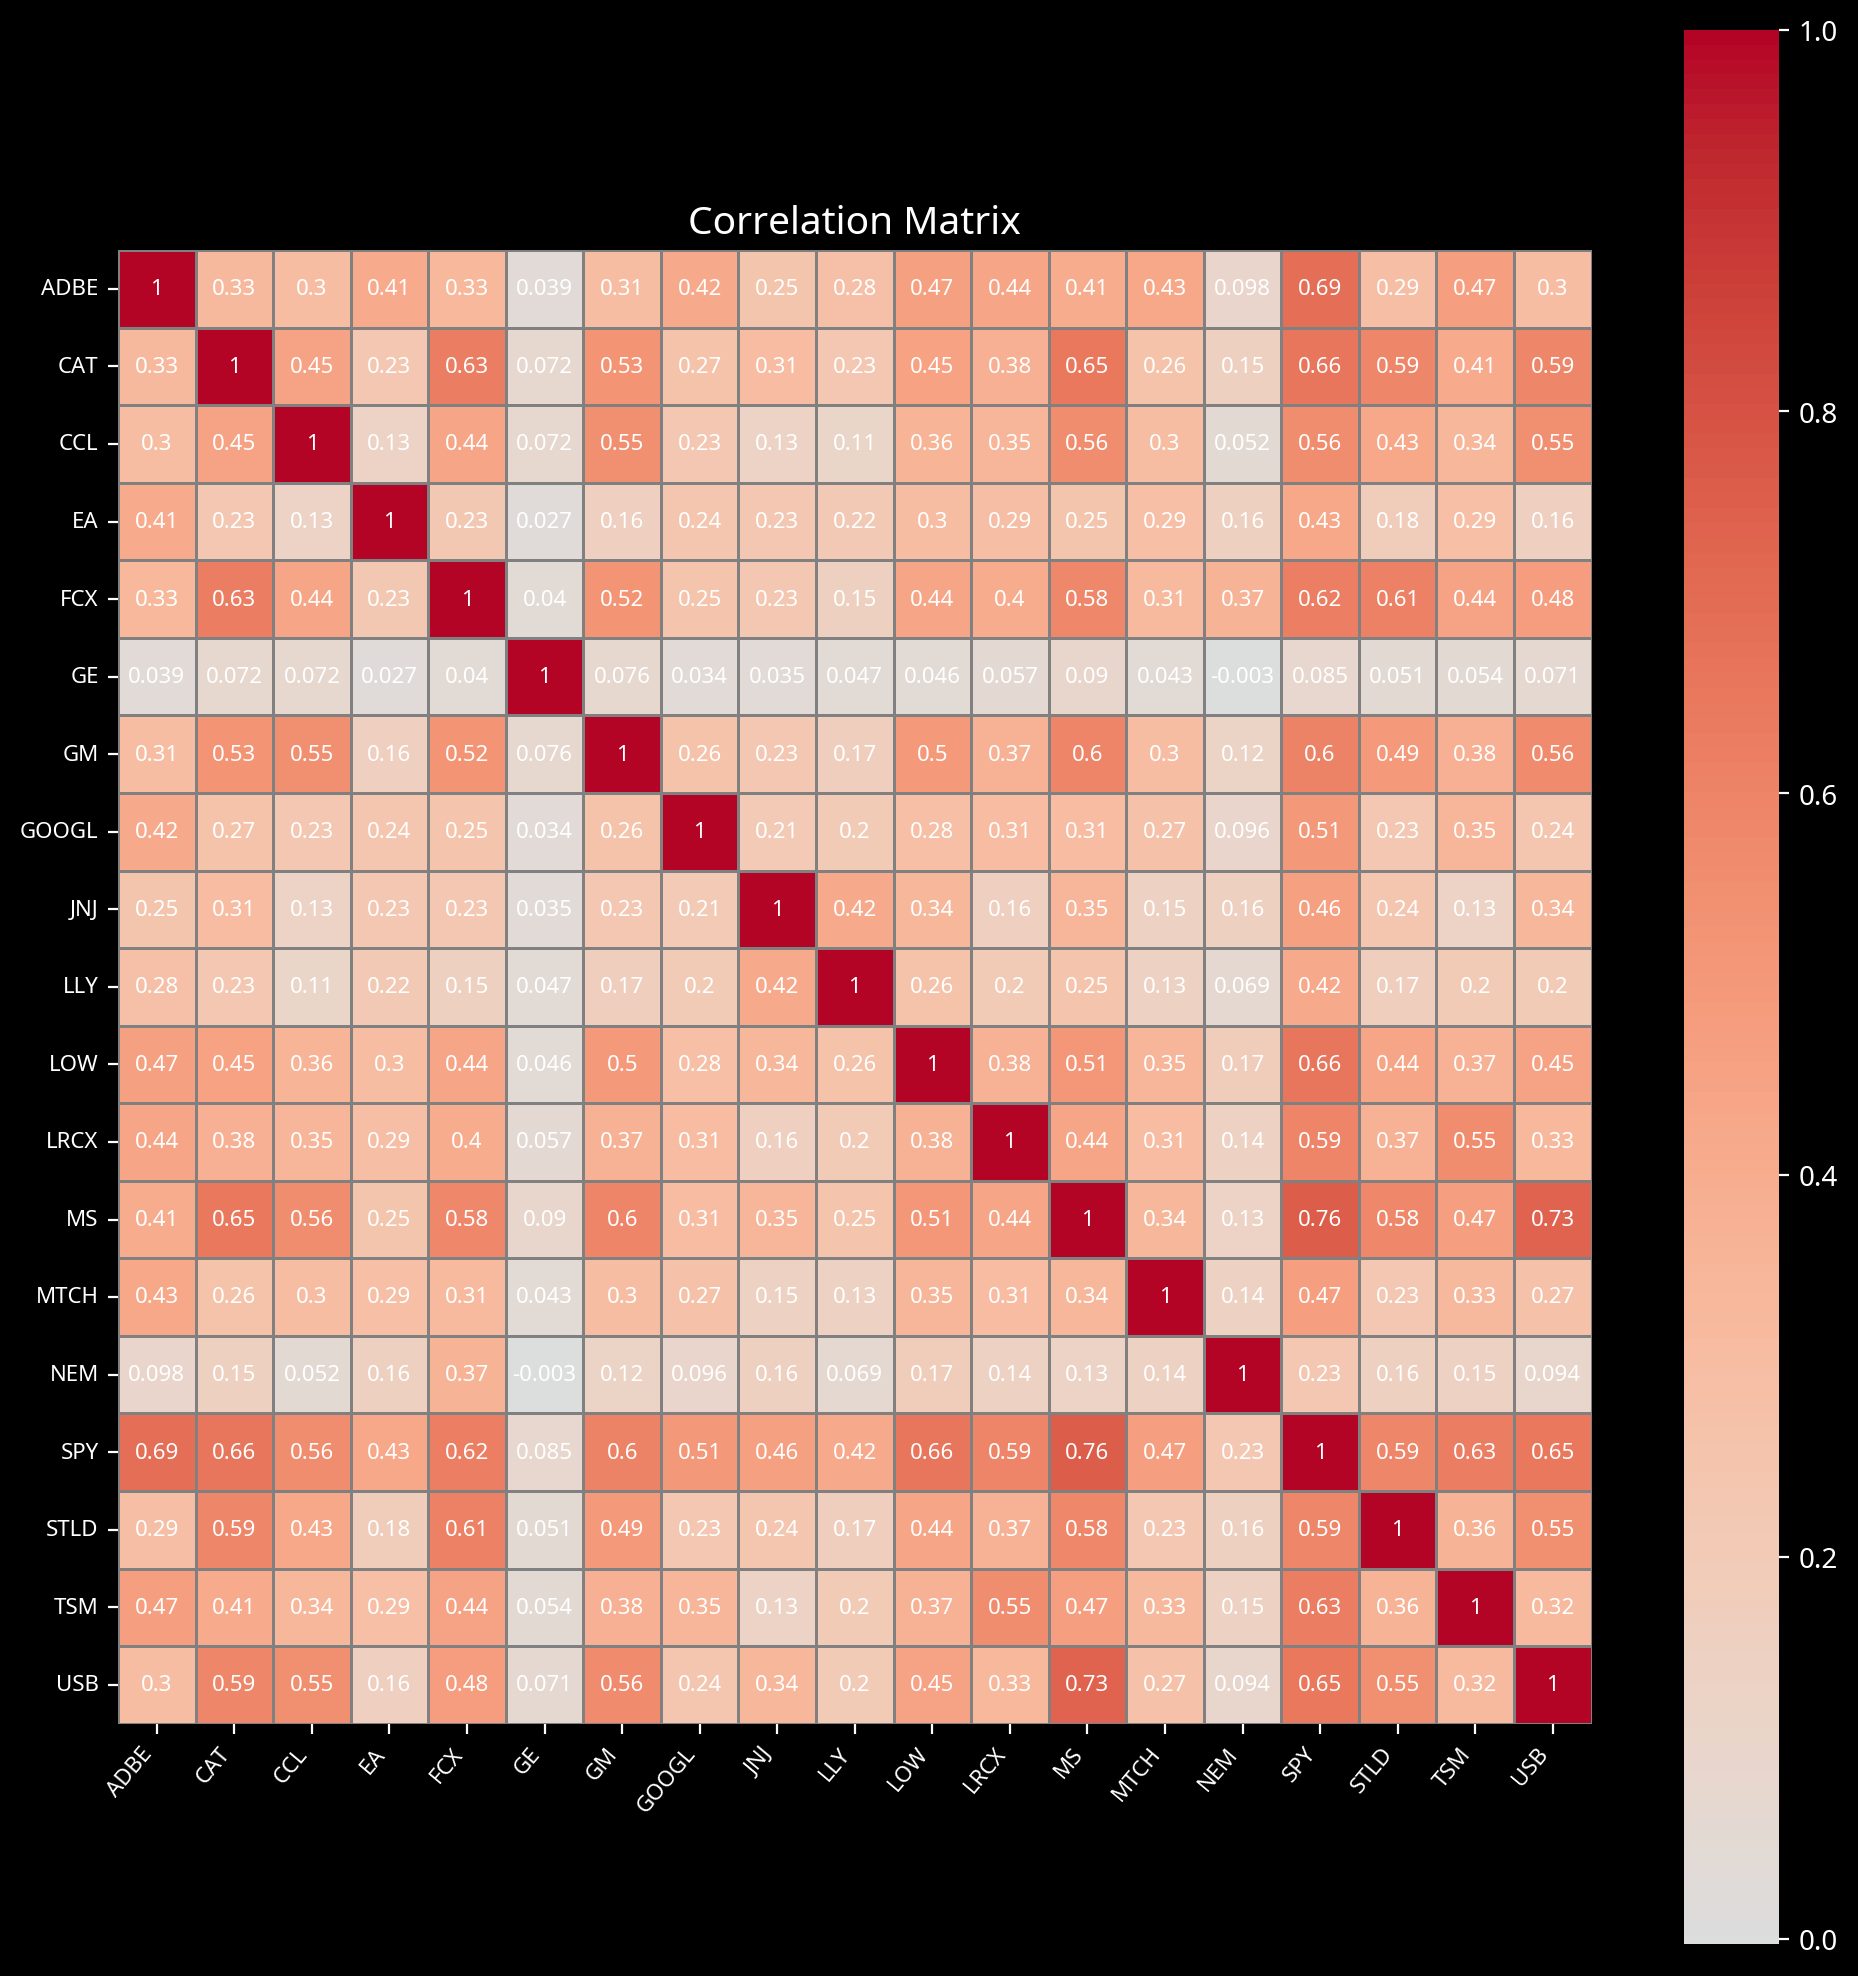

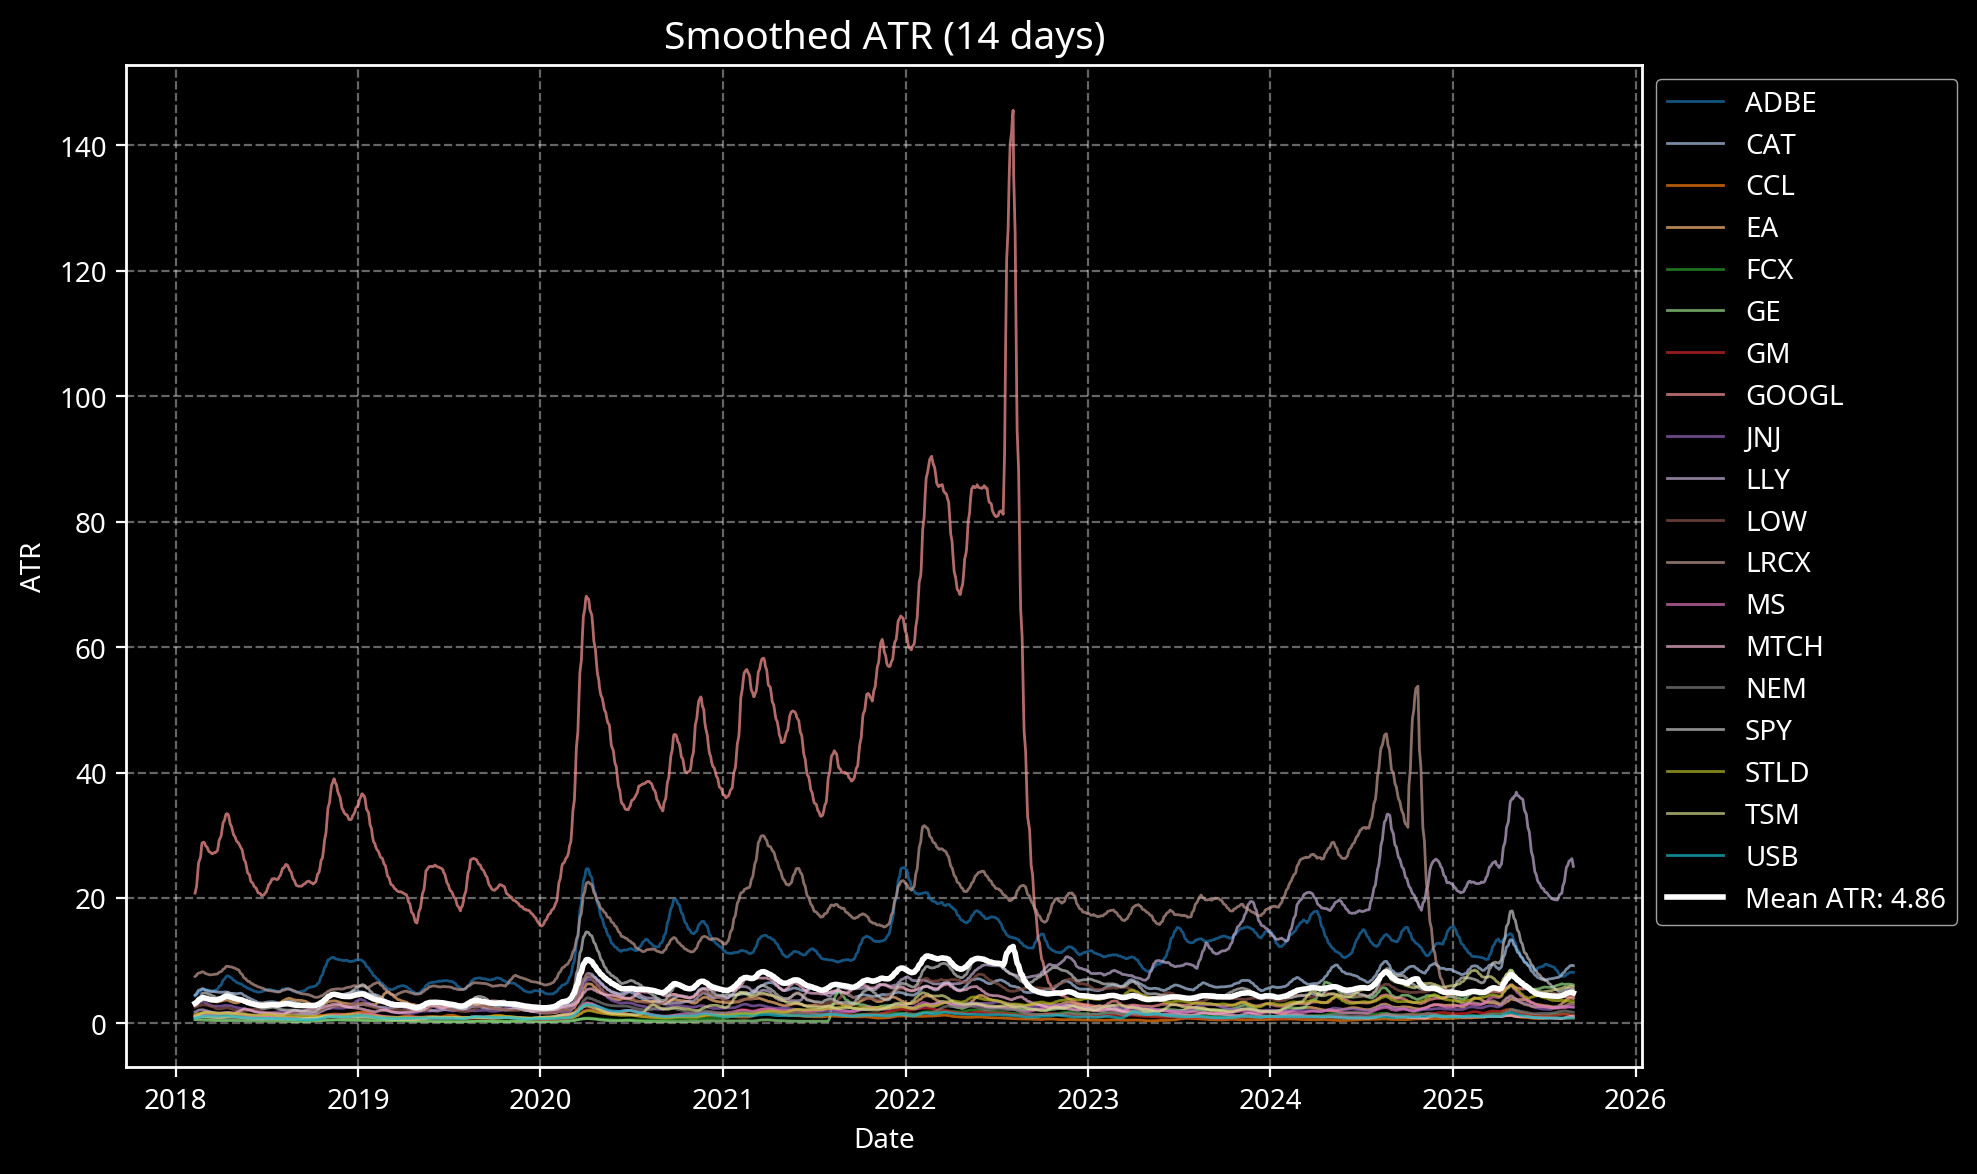

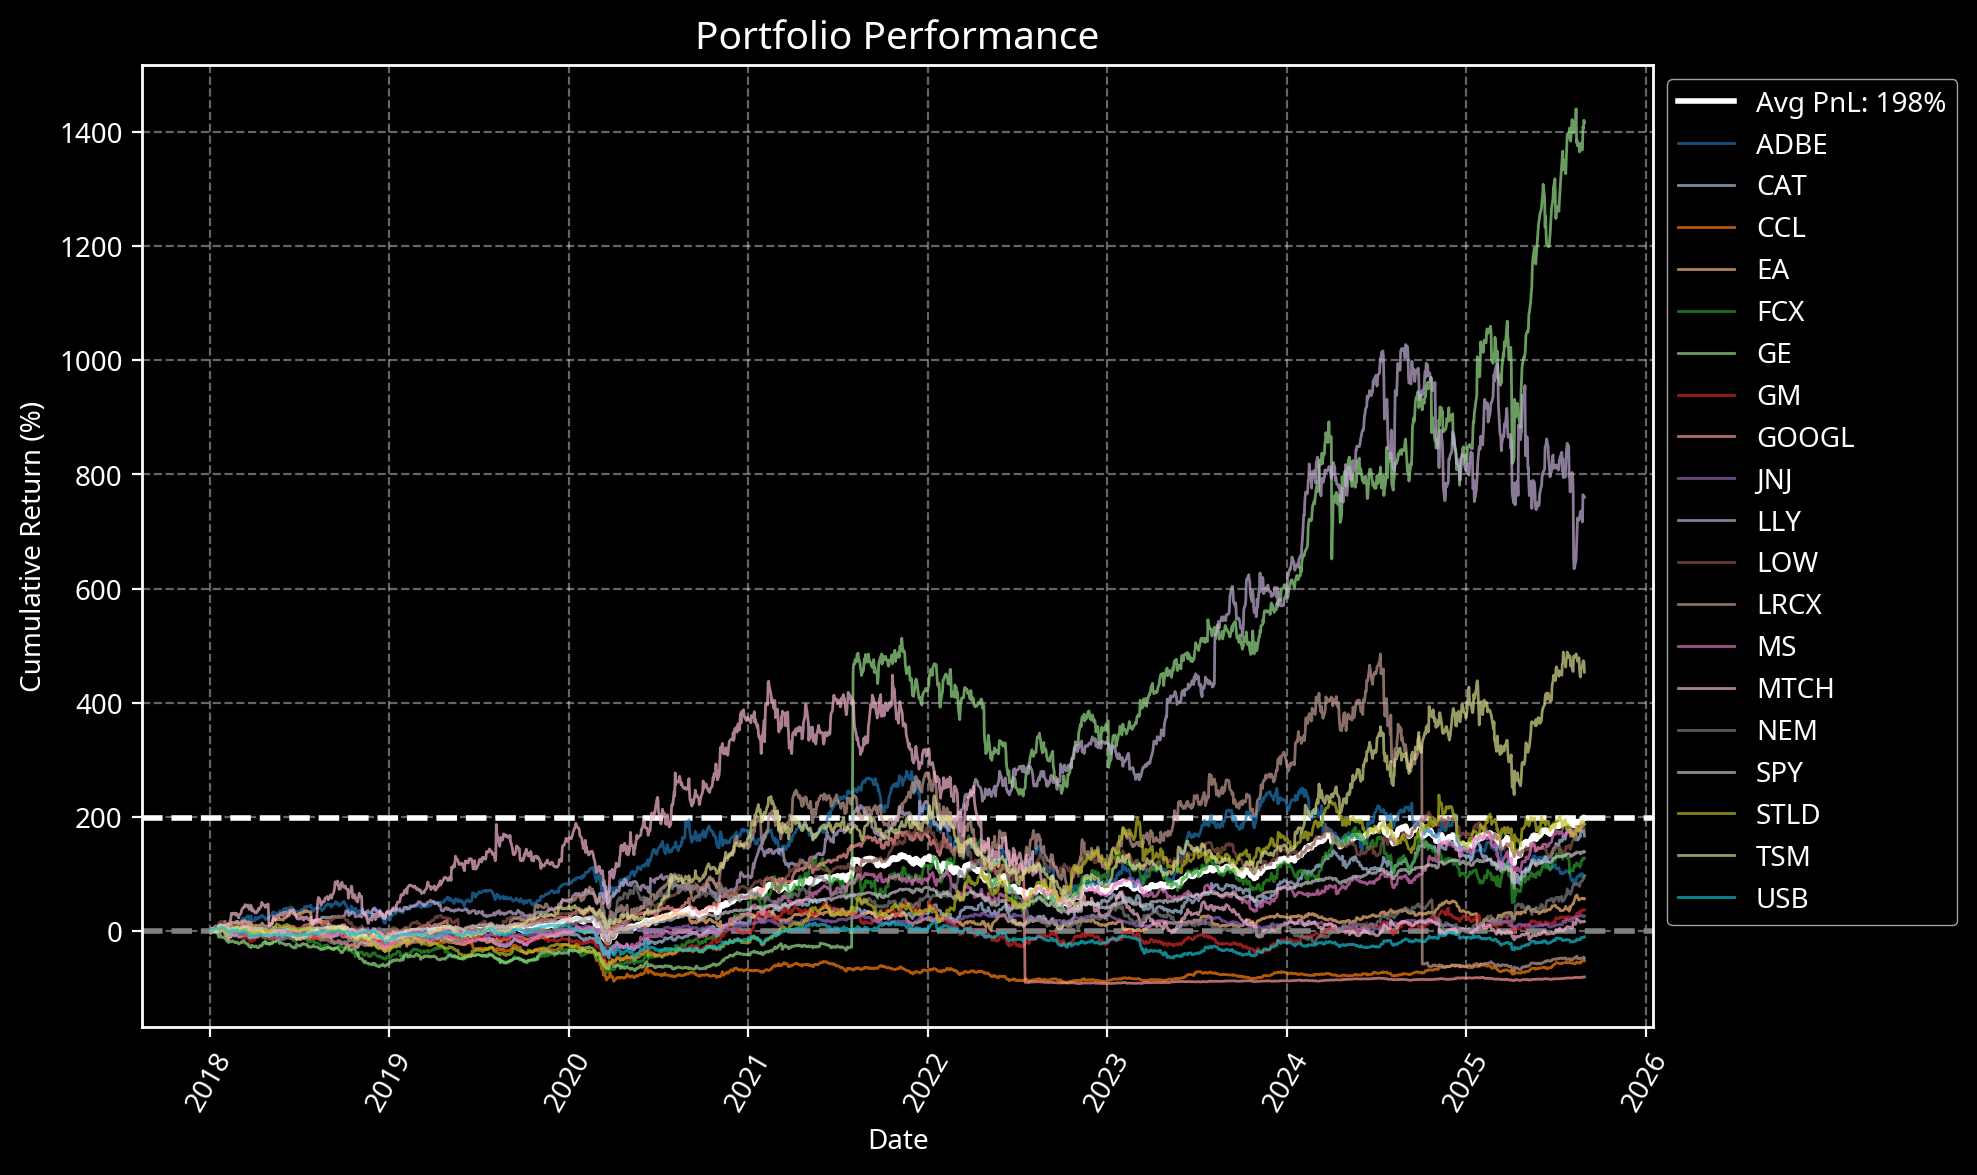

In [23]:
import requests
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import time
import os


plt.style.use('ggplot')
plt.style.use('dark_background')


class portfolio_insider():
    def __init__(self):
        with open('pf-insider-configs.json','r') as file:
            self.config_data = json.load(file)
            self.api_key = self.config_data['API-KEY'].strip()
            
        try:
            self.filename = input('Stock-List Name? ').strip()
        except FileNotFoundError:
            print("Fehler: Portfolio-Datei nicht gefunden.")
            return
        
        self.returns_df = pd.DataFrame()
        self.atr_sma_df = pd.DataFrame()

        try:
            with open(self.filename, 'r') as file:
                self.stocks = [line.strip() for line in file.readlines()]
        except FileNotFoundError:
            print(f'No such file as {self.filename}')
            print('Please create your portfolio with pf_manager.ipynb first.')
            return
        
        self.atr_length = int(input('ATR Length? '))
            
        self.save = bool(int(input('Save Plots? (0/1) ')))
        self.startdate = pd.to_datetime(input('Startdate? (YYYY-MM-DD) ').strip())
        
        self.performance_df = pd.DataFrame()
                                           
        print(f'\nLoading and processing {len(self.stocks)} stocks. This may take a moment...\n')
        
        for symbol in self.stocks:
            df = None
            csv_path = f'{symbol}-ohlc.csv'
            if os.path.exists(csv_path):
                try:
                    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except Exception as e:
                    print(f"Fehler beim Lesen von {csv_path}: {e}")
                    continue
            
            if df is None:
                print(f"Requesting data for {symbol} from API...")
                url = (
                    f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={self.api_key}')
                response = requests.get(url)
                data = response.json()
                
                if response.status_code != 200 or "Error Message" in data:
                    print(f"Failed to retrieve data for {symbol}. Skipping...")
                    continue
                if "Note" in data:
                    print(f"API limit reached: {data['Note']}")
                    return
                if "Time Series (Daily)" not in data:
                    print(f"Error at {symbol}: {data}")
                    continue
                
                ts_data = data["Time Series (Daily)"]
                df = pd.DataFrame.from_dict(ts_data, orient='index')
                df.index = pd.to_datetime(df.index)
                df = df.rename(columns={
                    '1. open': 'Open',
                    '2. high': 'High',
                    '3. low': 'Low',
                    '4. close': 'Close'
                })
                try:
                    df = df[['Open', 'High', 'Low', 'Close']].astype(float)
                    df.to_csv(csv_path)
                    print(f"Saved data for {symbol} to {csv_path}.")
                    time.sleep(12)  
                except Exception as e:
                    print(f"Error processing {symbol} data: {e}")
                    continue
            
            df = df[df.index >= self.startdate].sort_index()
            if df.empty:
                print(f"No data for {symbol} after {self.startdate.date()}. Skipping.")
                continue
            
            returns = df['Close'].pct_change().dropna()
            
            cumulative = (1 + returns).cumprod()
            scaled = cumulative / cumulative.iloc[0] - 1
            
            self.performance_df[symbol] = scaled
            
            if self.returns_df.empty:
                self.returns_df = returns.to_frame(name=symbol)
            else:
                self.returns_df = self.returns_df.join(returns.to_frame(name=symbol), how='inner')
            
            if len(df) >= self.atr_length:
                atr = ta.atr(high=df['High'], low=df['Low'], close=df['Close'], length=self.atr_length)
                atr_sma = atr.rolling(window=self.atr_length).mean()
                self.atr_sma_df[symbol] = atr_sma
            else:
                self.atr_length = 1
                atr = ta.atr(high=df['High'], low=df['Low'], close=df['Close'], length=self.atr_length)
                atr_sma = atr.rolling(window=self.atr_length).mean()
                self.atr_sma_df[symbol] = atr_sma
                
    def get_correlations(self):
        if self.returns_df.empty:
            print("No return data available.")
            return

        corr = self.returns_df.corr()
        
        plt.figure(figsize=(10,10))
        sns.heatmap(corr, cbar=True, cmap='coolwarm', center=0, annot=True, annot_kws={'size':8,'color':'white'},
                    linewidths=0.5, linecolor='gray', square=True)
        plt.title("Correlation Matrix", size=14, fontweight='bold')
        plt.xticks(rotation=50, ha='right', fontsize=8) 
        plt.yticks(fontsize=8)
        plt.tight_layout()
        
        if self.save:
            plt.savefig(f'{self.filename}-corrmatrix.png', dpi=300)
        plt.show()

    def get_atr(self):
        if self.atr_sma_df.empty:
            print("No ATR data available.")
            return
        
        plt.figure(figsize=(10,6))
        colors = sns.color_palette("tab20", n_colors=len(self.atr_sma_df.columns))
        
        for i, symbol in enumerate(self.atr_sma_df.columns):
            plt.plot(self.atr_sma_df[symbol], label=symbol, color=colors[i],linewidth=1,alpha=0.7)
        
        mean_atr = self.atr_sma_df.mean(axis=1)
        plt.plot(mean_atr.index, mean_atr,linewidth=2, color='white', label=f'Mean ATR: {mean_atr.iloc[-1]:.2f}')
        
        plt.title(f'Smoothed ATR ({self.atr_length} days)', size=14, fontweight='bold')
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('ATR', fontsize=10)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
        plt.grid(True, alpha=0.4,linestyle='--')
        plt.tight_layout()
        
        if self.save:
            plt.savefig(f'{self.filename}-satr.png', dpi=300, bbox_inches='tight')
        plt.show()

    def get_performance(self):
        if self.returns_df.empty or self.performance_df.empty:
            print("No performance data available.")
            return
        
        plt.figure(figsize=(10,6))
        avg_perf = self.performance_df.mean(axis=1) * 100
        
        plt.plot(avg_perf.index, avg_perf, linewidth=2, color='white', label=f'Avg PnL: {round(avg_perf.iloc[-1])}%')
        plt.axhline(avg_perf.iloc[-1], linewidth=2, linestyle='dashed', color='white')
        plt.axhline(0, linewidth=2, linestyle='--', color='gray')
        
        colors = sns.color_palette("tab20", n_colors=len(self.stocks))
        for i, symbol in enumerate(self.stocks):
            if symbol in self.performance_df:
                plt.plot(self.performance_df.index, self.performance_df[symbol]*100, label=symbol,
                         color=colors[i],linewidth=1, alpha=0.7)
        
        plt.title('Portfolio Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Cumulative Return (%)', fontsize=10)
        
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
        
        plt.grid(True, alpha=0.4,linestyle='--')
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
        plt.xticks(rotation=60)
        plt.tight_layout() 
        
        if self.save:
            plt.savefig(f'{self.filename}-returns.png', dpi=300, bbox_inches='tight')
        plt.show()
        
if __name__ == '__main__':
    portfolio = portfolio_insider()
    portfolio.get_correlations()
    portfolio.get_atr()
    portfolio.get_performance()